# Loop to implemet parallel processing and compute flux

In [ ]:
import numpy as np                  #import all necessary modules
import multiprocessing as mp
import gt_apps as gt
import time
import pyLikelihood
from BinnedAnalysis import *
import os

os.chdir("/home/b7009348/projects/fermi-data/FermiLAT_Data_J1023") #change to directory containing data

begin = time.time()
start = 239557417 #start of fermi mission
end = 607305605 #final time for data downloaded
binsz = 2000000 #size of bins wanted
diff = end - start #time of fermi mission
numbins = diff/binsz #number of bins
i = 1 #preallocate iterable

while i <= numbins/10+1: #while loop generates lists until max number in bins is reached at element of a list
    
    if i <= numbins/10: 
        x = list(range(1,11)) #creates an integer list from 1-10 used to pool cpus, label files and calculate times
        for j in range(0,10):
            x[j] = x[j] +((i-1)*10) #for increasing i, each element of the list goes up by 10
        print x
        print 'CPUs =', len(x) 
        pool = mp.Pool(len(x)) #pools 10 cpus to calcuate 10 bins
    else: #when the next list will exceed the final bin, the else statement shorten that list 
        #to end on the final bin
        limit = numbins-x[9] #calculates what length the list should be to not exceed bin number
        x = list(range(1,int(limit+1))) #generates a smaller list ending with final bin
        for j in range(0,int(limit)): 
            x[j] = x[j] +((i-1)*10) #sets each element to the appropriate value
        print x
        print 'CPUs =', len(x)
        pool = mp.Pool(len(x)) #pools as many cpus as there are bins left to calculate (<10)
    
    pool.map(fermitools, x) #runs the function in parallel on multiple cpus
    
    for j in range(0,len(x)): #this loops generates the likelihood objects wanted and writes the flux to .txt
        
        obs = BinnedObs(srcMaps='J1023_srcMap-'+str(x[j])+'.fits', #binned objects
                    expCube='J1023_ltcube-'+str(x[j])+'.fits', binnedExpMap='J1023_expCube-'+str(x[j])+'.fits', 
                    irfs='CALDB')
        like = BinnedAnalysis(obs, 'J1023_model_fixed.xml', optimizer='NEWMINUIT')

        likeobj = pyLike.NewMinuit(like.logLike) #likelihood fitting 
        like.fit(verbosity=0,covar=True,optObject=likeobj) #save output to xml

        if likeobj.getRetCode() == 0: #test if newminuit converged 

            like.logLike.writeXml('J1023_binned_output-'+str(x[j])+'.xml') #write required data to .txt
            f = open('LightCurvePoints.txt','a')
            f.write
            f.write('Bin start = '+str(start+(x[j]-1)*binsz)+' Flux = '
                    +str(like.flux('4FGL J1023.7+0038', emin=100))+'+/-'+str
                    (like.fluxError('4FGL J1023.7+0038', emin=100)))
            f.write('\n')
            f.close()
            os.remove('J1023_srcMap-'+str(x[j])+'.fits') 
            #remove unwanted large files

        else:
            print 'Analysis did not converge' #error message in case something goes wrong
        
    i = i +1 #increase counter for next iteration
    
end = time.time()
print('runtime =',end - begin)


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
CPUs = 10
time -p gtselect infile=photons.fits outfile=J1023_filtered-2.fits ra="INDEF" dec="INDEF" rad=20.0 tmin=241557417.0 tmax=243557417.0 emin=100.0 emax=500000.0 zmin=0.0 zmax=90.0 evclass=128 evtype=3 convtype=-1 phasemin=0.0 phasemax=1.0 evtable="EVENTS" chatter=2 clobber=yes debug=no gui=no mode="ql"
time -p gtselect infile=photons.fits outfile=J1023_filtered-1.fits ra="INDEF" dec="INDEF" rad=20.0 tmin=239557417.0 tmax=241557417.0 emin=100.0 emax=500000.0 zmin=0.0 zmax=90.0 evclass=128 evtype=3 convtype=-1 phasemin=0.0 phasemax=1.0 evtable="EVENTS" chatter=2 clobber=yes debug=no gui=no mode="ql"
time -p gtselect infile=photons.fits outfile=J1023_filtered-4.fits ra="INDEF" dec="INDEF" rad=20.0 tmin=245557417.0 tmax=247557417.0 emin=100.0 emax=500000.0 zmin=0.0 zmax=90.0 evclass=128 evtype=3 convtype=-1 phasemin=0.0 phasemax=1.0 evtable="EVENTS" chatter=2 clobber=yes debug=no gui=no mode="ql"
time -p gtselect infile=photons.fits outfile=J1023_filt

# Function to generate files for likelihood analysis

In [8]:
def fermitools(x, binsz=2000000): #x can range from 1 to 183
    
    tmin = 239557417 + (x-1)*binsz
    tmax = 239557417 + x*binsz
        
    gt.filter['evclass'] = 128
    gt.filter['evtype'] = 3
    gt.filter['rad'] = 20
    gt.filter['zmax'] = 90
    gt.filter['tmin'] = tmin
    gt.filter['tmax'] = tmax
    gt.filter['emin'] = 100
    gt.filter['emax'] = 500000
    gt.filter['infile'] = 'photons.fits'
    gt.filter['outfile'] = 'J1023_filtered-'+str(x)+'.fits'
    gt.filter.run()

    gt.maketime['scfile'] = 'spacecraft.fits'
    gt.maketime['filter'] = '(DATA_QUAL>0)&&(LAT_CONFIG==1)'
    gt.maketime['roicut'] = 'no'
    gt.maketime['evfile'] = 'J1023_filtered-'+str(x)+'.fits'
    gt.maketime['outfile'] = 'J1023_gti-'+str(x)+'.fits'
    gt.maketime.run()

    gt.evtbin['evfile'] = 'J1023_gti-'+str(x)+'.fits'
    gt.evtbin['scfile'] = 'spacecraft.fits'
    gt.evtbin['outfile'] = 'J1023_cmap-'+str(x)+'.fits'
    gt.evtbin['algorithm'] = 'CMAP'
    gt.evtbin['emin'] = 100
    gt.evtbin['xref'] = 155.94868346
    gt.evtbin['yref'] = 0.64472416
    gt.evtbin['emax'] = 500000
    gt.evtbin['nxpix'] = 150
    gt.evtbin['nypix'] = 150
    gt.evtbin['binsz'] = 0.2
    gt.evtbin['coordsys'] = 'CEL'
    gt.evtbin['axisrot'] = 0.0
    gt.evtbin['proj'] = 'AIT'
    gt.evtbin['rafield'] = 'RA'
    gt.evtbin['decfield'] = 'DEC'
    gt.evtbin.run()

    gt.evtbin['evfile'] = 'J1023_gti-'+str(x)+'.fits'
    gt.evtbin['scfile'] = 'spacecraft.fits'
    gt.evtbin['outfile'] = 'J1023_ccube-'+str(x)+'.fits'
    gt.evtbin['algorithm'] = 'CCUBE'
    gt.evtbin['emin'] = 100
    gt.evtbin['xref'] = 155.94868346
    gt.evtbin['yref'] = 0.64472416
    gt.evtbin['emax'] = 500000
    gt.evtbin['nxpix'] = 100
    gt.evtbin['nypix'] = 100
    gt.evtbin['binsz'] = 0.2
    gt.evtbin['coordsys'] = 'CEL'
    gt.evtbin['axisrot'] = 0.0
    gt.evtbin['proj'] = 'AIT'
    gt.evtbin['rafield'] = 'RA'
    gt.evtbin['decfield'] = 'DEC'
    gt.evtbin['ebinalg'] = 'LOG'
    gt.evtbin['enumbins'] = 37
    gt.evtbin.run()

    gt.expCube['evfile'] = 'J1023_gti-'+str(x)+'.fits'
    gt.expCube['scfile'] = 'spacecraft.fits'
    gt.expCube['outfile'] = 'J1023_ltcube-'+str(x)+'.fits'
    gt.expCube['zmax'] = 90
    gt.expCube['dcostheta'] = 0.025
    gt.expCube['binsz'] = 1
    gt.expCube.run()

    gt.expMap['evfile'] = 'J1023_gti-'+str(x)+'.fits'
    gt.expMap['scfile'] = 'spacecraft.fits'
    gt.expMap['expcube'] = 'J1023_ltcube-'+str(x)+'.fits'
    gt.expMap['outfile'] = 'J1023_expMap-'+str(x)+'.fits'
    gt.expMap['irfs'] = 'CALDB'
    gt.expMap['srcrad'] = 20
    gt.expMap['nlong'] = 120
    gt.expMap['nlat'] = 120
    gt.expMap['nenergies'] = 37
    gt.expMap.run()

    gt.gtexpcube2['infile'] = 'J1023_ltcube-'+str(x)+'.fits'
    gt.gtexpcube2['outfile'] = 'J1023_expCube-'+str(x)+'.fits'
    gt.gtexpcube2['cmap'] = 'none'
    gt.gtexpcube2['irfs'] = 'P8R3_SOURCE_V2'
    gt.gtexpcube2['nxpix'] = 300
    gt.gtexpcube2['nypix'] = 300
    gt.gtexpcube2['binsz'] = 0.7
    gt.gtexpcube2['coordsys'] = 'CEL'
    gt.gtexpcube2['xref'] = 155.94868346
    gt.gtexpcube2['yref'] = 0.64472416
    gt.gtexpcube2['axisrot'] = 0
    gt.gtexpcube2['proj'] = 'AIT'
    gt.gtexpcube2['emin'] = 100
    gt.gtexpcube2['emax'] = 500000
    gt.gtexpcube2['enumbins'] = 37
    gt.gtexpcube2.run()

    gt.srcMaps['expcube'] = 'J1023_ltcube-'+str(x)+'.fits'
    gt.srcMaps['cmap'] = 'J1023_ccube-'+str(x)+'.fits'
    gt.srcMaps['srcmdl'] = 'J1023_model_fixed.xml'
    gt.srcMaps['bexpmap'] = 'J1023_expCube-'+str(x)+'.fits'
    gt.srcMaps['outfile'] = 'J1023_srcMap-'+str(x)+'.fits'
    gt.srcMaps['irfs'] = 'CALDB'
    gt.srcMaps.run()
    
    return;

# Code required to write flux and error to .txt

In [ ]:
obs = BinnedObs(srcMaps='J1023_srcMap-'+str(x)+'.fits', 
                    expCube='J1023_ltcube-'+str(x)+'.fits', binnedExpMap='J1023_expCube-'+str(x)+'.fits', 
                    irfs='CALDB')
like = BinnedAnalysis(obs, 'J1023_model_fixed.xml', optimizer='NEWMINUIT')

#run analysis and save output to xml
likeobj = pyLike.NewMinuit(like.logLike) 
like.fit(verbosity=0,covar=True,optObject=likeobj)

#test if newminuit converged
if likeobj.getRetCode() == 0:

    like.logLike.writeXml('J1023_binned_output-'+str(x)+'.xml')
    f = open('LightCurvePoints.txt','a')
    f.write(str(like.flux('4FGL J1023.7+0038', emin=100))+'+/-'+str
        (like.fluxError('4FGL J1023.7+0038', emin=100)))
    f.write('\n')
    f.close()
    os.remove('J1023_srcMap-'+str(x)+'.fits')

else:
    print 'Analysis did not converge'

In [7]:
for x in range(0,10):
    f = open('LightCurvePoints.txt','a')
    f.write('yahyeet')
    f.write('\n')
    f.close()


# Light Curve Plotting

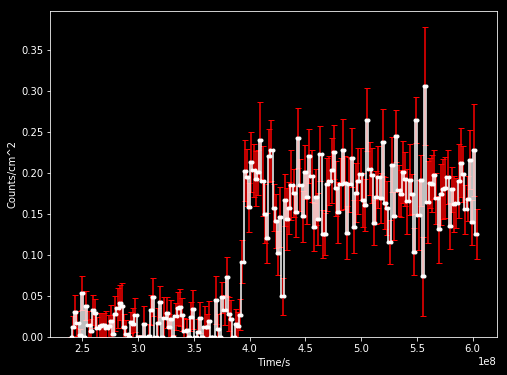

In [92]:
import os
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')

os.chdir("/home/b7009348/projects/fermi-data/FermiLAT_Data_J1023")

data = np.loadtxt('LightCurvePoints-Copy1.txt')

time = data[:,0]
flux = data[:,1] #photons per cm^2 per s
flux_error= data[:,2]

binsz = 2000000

counts = flux*binsz #photons per cm^2
counts_error = flux_error*binsz #error in counts


plt.errorbar(time,counts,yerr=counts_error,marker='.',color='white',ecolor='red',drawstyle='steps-mid',capsize=3)
#plt.step(time,counts,color='blue')
plt.ylim(ymin=0)
plt.xlabel('Time/s')
plt.ylabel('Counts/cm^2')
plt.gcf().set_size_inches(8,6)
plt.savefig('LC.pdf')
plt.show()